In [4]:
import sys, os, json, subprocess
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [5]:
import sit_helper
standard_import_tool_plugin_path=sit_helper.load_standard_import_tool_plugin()
import cbm3_python_helper
cbm3_python_helper.load_cbm3_python()
import cbm3_python.simulation.projectsimulator
from cbm3_python.cbm3data.accessdb import AccessDB

The following code demonstrates the [StandardImportToolPlugin](https://github.com/cat-cfs/StandardImportToolPlugin).  The simulation definition is built using the SITConfig helper class, and then imported via the Operational-Scale CBM-CFS3 standard import tool.  The simulation is a replica of the CBM3 Tutorial1 afforestation project.

In [20]:
project_path = r".\tutorial1\tutorial1.mdb"
results_db_path = r".\tutorial1\tutorial1_results.mdb"
config_save_path = "config.json"

c = sit_helper.SITConfig(
    imported_project_path=project_path,
    initialize_mapping=True
)
c.data_config(
    age_class_size=5,
    num_age_classes=14,
    classifiers=["Stand ID", "Leading Species", "Land Cover"])

c.set_single_spatial_unit(17)
c.set_species_classifier("Leading Species")
c.map_species("Nonforest", "Not stocked")


#define 3 inventory areas each with a different initial soil type
c.add_inventory(classifier_set=["Stand 1", "Luvisolic (E. Canada)", "Nonforest"], area=10, age=0, unfccc_land_class=1)
c.add_inventory(classifier_set=["Stand 2", "Brunisolic", "Nonforest"], area=10, age=0, unfccc_land_class=1)
c.add_inventory(classifier_set=["Stand 3", "Average", "Nonforest"], area=10, age=0, unfccc_land_class=1)

#afforest the stands on the forst time step
c.add_event(classifier_set=["?","?","?"], disturbance_type="Afforestation", 
              time_step=1, target=30, target_type="Area", sort="SORT_BY_SW_AGE")

#add a harvest event on timestep 100 that applies to all inventory records
c.add_event(classifier_set=["?","?","?"], disturbance_type="Clear-cut with slash-burn",
              time_step=100, target=30, target_type="Area", sort="SORT_BY_SW_AGE")

#add a fire event on timestep 150 that applies to all inventory records
c.add_event(classifier_set=["?","?","?"], disturbance_type="Wildfire", 
              time_step=150, target=30, target_type="Area", sort="SORT_BY_SW_AGE")

#for the Afforestation event, transition stands to Red Pine forest
c.add_transition_rule(
    classifier_set_source=["?","?","?"],
    classifier_set_target=["?","Red pine","Forest Only"],
    disturbance_type="Afforestation", percent=100)

#the growth curve as defined in the operational-scale cbm3 tutorial1
growth_curve_data = [0,0,0,27,84,155,217,271,317,353,382,406,426,426]

#an empty growth curve for non-growing (pre-afforestation) stands
not_stocked_growth = [0.0]*len(growth_curve_data)

c.add_yield(classifier_set=["?","?","Nonforest"],
            leading_species_classifier_value="Not stocked",
            values=not_stocked_growth)

#assign the growth curve data to the post-afforestation Red Pine forest
c.add_yield(classifier_set=["?","Red pine","Forest Only"], 
            leading_species_classifier_value="Red pine", values=growth_curve_data)

c.import_project(standard_import_tool_plugin_path, config_save_path)


C:\dev\cbm3_scripting_examples


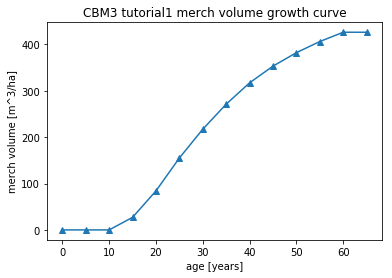

In [21]:
#plot the merch volume
plt.plot(range(0,len(growth_curve_data)*5,5), growth_curve_data, marker='^')
plt.title("CBM3 tutorial1 merch volume growth curve")
plt.ylabel("merch volume [m^3/ha]")
plt.xlabel("age [years]")
print(os.getcwd())

In [22]:
toolbox_path = r'C:\Program Files (x86)\Operational-Scale CBM-CFS3'
results_db_path = cbm3_python.simulation.projectsimulator.run(
    aidb_path=os.path.join(toolbox_path, "admin", "dbs", "ArchiveIndex_Beta_Install.mdb"), 
    project_path=os.path.abspath(project_path), 
    toolbox_installation_dir=toolbox_path,
    cbm_exe_path=os.path.join(toolbox_path, "admin", "executables"),
    results_database_path= results_db_path,
    afforestation_only=True)

In [23]:
bioPools = ['SW_Merch','SW_Foliage','SW_Other','SW_subMerch','SW_Coarse','SW_Fine',
            'HW_Merch','HW_Foliage','HW_Other','HW_subMerch','HW_Coarse','HW_Fine']

domPools = ['VFastAG','VFastBG','FastAG','FastBG','Medium', 'SlowAG','SlowBG','SWStemSnag',
            'SWBranchSnag','HWStemSnag','HWBranchSnag','BlackCarbon','Peat']

timeStep = "TimeStep"
classid= "UserDefdClassSetID"
print(results_db_path)

.\tutorial1\tutorial1_results.mdb


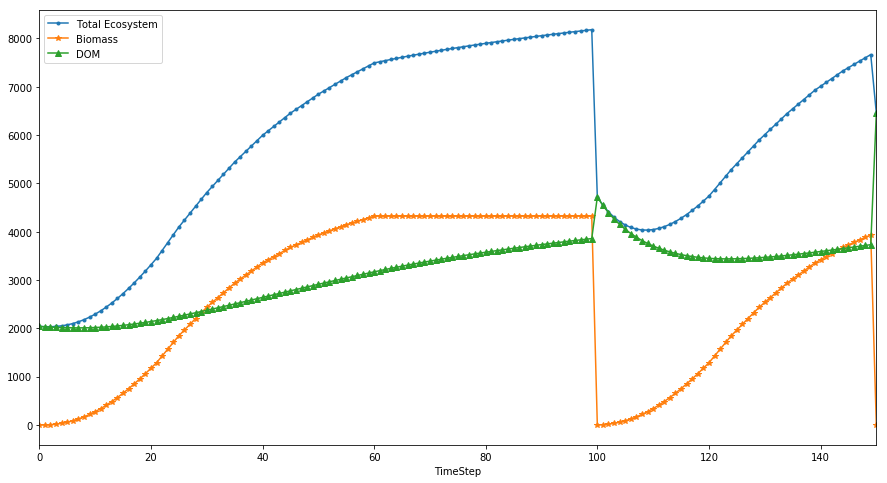

In [25]:
with AccessDB(results_db_path) as results_db:
    df = pd.read_sql("select * from tblPoolIndicators", results_db.connection)
    #print(list(df))
total_eco_pools = []
total_eco_pools.extend(bioPools)
total_eco_pools.extend(domPools)
total_biomass = pd.concat([
        df[timeStep],
        df[total_eco_pools].sum(axis=1),
        df[bioPools].sum(axis=1),
        df[domPools].sum(axis=1)
    ], axis=1).groupby(timeStep).sum()

total_biomass.columns=["Total Ecosystem","Biomass","DOM"]
total_biomass.plot(kind='line', figsize=(15,8),  style=['.-','-*','-^'])



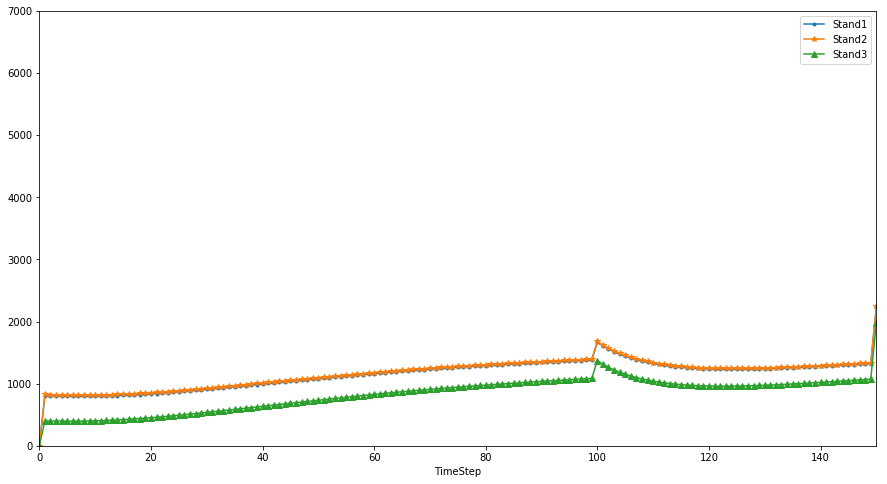

In [30]:
stand1 = df.loc[df["UserDefdClassSetID"]==6][domPools].sum(axis=1)
stand2 = df.loc[df["UserDefdClassSetID"]==7][domPools].sum(axis=1)
stand3 = df.loc[df["UserDefdClassSetID"]==8][domPools].sum(axis=1)

dom_by_class = pd.concat([
        df[timeStep],
        stand1,
        stand2,
        stand3
    ], axis=1).groupby([timeStep]).sum()

dom_by_class.columns=["Stand1","Stand2","Stand3"]
dom_by_class.plot(kind='line', figsize=(15,8), 
                  ylim=(0,7e3), xlim=(0,150),
                  style=['.-','-*','-^'])